In [ ]:
import numpy as np
import torch
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
import os
# torchvision提供数据集的下载
from torchvision import datasets, transforms,utils
import torch.optim as optim
import torch.nn.functional as F
plt.rcParams['font.sans-serif']=['simhei']   #用于正常显示中文标签
plt.rcParams['axes.unicode_minus']=False     #用于正常显示负号
# 如果GPU可用则使用GPU, 否则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 加载数据

In [2]:
# 给定均值和方差,将数据进行归一化后,又进行了正则化:Normalized_image=(image-mean)/std  
#  由于只有灰度值,所以传入的维度只有1维
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5],std=[0.5])])
# 加载训练集
train_data = datasets.MNIST(root = '/data',transform=transform,train = True,download = True)
# 加载测试集
test_data = datasets.MNIST(root='/data',transform = transform,train = False)

# shuffle 表示再加载数据时将数据打乱
# num_workers 表示用多少个子进程加载数据
train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True,num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=64,shuffle=True,num_workers=2)
for pics,label in test_loader:
    print(len(pics),len(pics[0]),len(pics[0][0]),len(pics[0][0][0]))

64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28
64 1 28 28

### 创建评估类

In [3]:
class Evaluator:
    # resultList为传入的分类结果列表，每一行代表不同的类，第0列代表正确分类的个数(TP)，第一列代表被分为该类的样本总数，第二列代表应分为该类的样本数

    def __init__(self)->None:
        self.ClassResult={i:[] for i in range(10)}
        self.MacroAvg=[]
        self.MicroAvg=[]
        return 

    def addTrainResult(self,resultList,sampleSize) -> None:
        TP = [data[0] for data in resultList]  # 初始化TP列表
        FN = [data[2]-data[0] for data in resultList]  # 初始化FN列表
        FP = [data[1]-data[0] for data in resultList]  # 初始化FP列表
        TN = [sampleSize-data[2]+data[0]-data[1] for data in resultList]  # 初始化TN列表
        Accuracy = [(tp+tn)/sampleSize for tp,tn in zip(TP,TN)]  # 初始化正确率
        Precision = [tp/(tp+fp) if (tp+fp) != 0 else 0 for tp,fp in zip(TP,FP)]  # 初始化准确率
        Recall = [tp/(tp+fn) if (tp+fn) != 0 else 0 for tp,fn in zip(TP,FN)]  # 初始化召回率
        F_score = [2*p*r/(p+r) if (p+r) != 0 else 0 for p,r in zip(Precision,Recall)]  # 初始化F值
        t=self.getClassResult(Accuracy,Precision,Recall,F_score)
        for i in range(10):
            self.ClassResult[i].append(t[i])
        self.MacroAvg.append(self.getMacroAvg(Accuracy,Precision,Recall,F_score))
        self.MicroAvg.append(self.getMicroAvg(TP,FP,TN,FN,sampleSize))
        
    # 获取小类的识别率
    # 第0列为正确率 第1列为准确率 第2列为召回率 第3列为F值
    def getClassResult(self,Accuracy,Precision,Recall,F_score):
        return [[a,f,r,p] for a,f,r,p in zip(Accuracy,Precision,Recall,F_score)]

    # 获取宏平均 先计算各个小类的指标，再计算平均值
    # 列表的0 1 2 3分别为正确率、准确率、召回率、F值
    def getMacroAvg(self,Accuracy,Precision,Recall,F_score):
        averageAccuracy = sum(Accuracy)/len(Accuracy)
        averagePrecision = sum(Precision)/len(Precision)
        averageRecall = sum(Recall)/len(Recall)
        averageF_score = sum(F_score)/len(F_score)
        return [averageAccuracy,averagePrecision,averageRecall,averageF_score]
    
    # 获取微平均 先计算TP, FP, TN, FN的平均值，再计算指标
    # 列表的0 1 2 3分别为正确率、准确率、召回率、F值
    def getMicroAvg(self,TP,FP,TN,FN,sampleSize):
        averageTP = sum(TP)/len(TP)
        averageFP = sum(FP)/len(FP)
        averageTN = sum(TN)/len(TN)
        averageFN = sum(FN)/len(FN)
        averageAccuracy = (averageTP+averageTN)/sampleSize
        averagePrecision = averageTP/(averageTP+averageFP) if (averageTP+averageFP)!=0 else 0
        averageRecall = averageTP/(averageTP+averageFN) if (averageTP+averageFN)!=0 else 0
        averageF_score = 2*averagePrecision*averageRecall/(averagePrecision+averageRecall) if (averagePrecision+averageRecall)!=0 else 0
        return [averageAccuracy,averagePrecision,averageRecall,averageF_score]

    def plotvisual(self,col0,col1,col2,col3,title)->None:
        times=len(col0)
        x=[i for i in range(1,times+1)]
        fig,ax=plt.subplots()
        ax.set_xlabel('训练的次数')
        ax.set_xticks(range(1,times+1))
        ax.plot(x,col0,label='正确率')
        ax.plot(x,col1,label='准确率')
        ax.plot(x,col2,label='召回率')
        ax.plot(x,col3,label='F值')
        ax.set_title(title)
        ax.legend(); 
        return 

    def visual(self)->None:
        # 宏平均可视化
        self.plotvisual([i[0] for i in self.MacroAvg],[i[1] for i in self.MacroAvg],\
            [i[2] for i in self.MacroAvg],[i[3] for i in self.MacroAvg],'宏平均可视化')

        # 微平均可视化
        self.plotvisual([i[0] for i in self.MicroAvg],[i[1] for i in self.MicroAvg],\
            [i[2] for i in self.MicroAvg],[i[3] for i in self.MicroAvg],'微平均可视化')

        # 小类可视化
        for num in range(10):
            self.plotvisual([i[0] for i in self.ClassResult[num]],[i[1] for i in self.ClassResult[num]],\
            [i[2] for i in self.ClassResult[num]],[i[3] for i in self.ClassResult[num]],'{}的可视化'.format(num))

        return 

### 定义CNN网络  
网络的结构是 2个卷积层+3个全连接层  

In [10]:
class CNN(nn.Module):
    def __init__(self):
        """
        构造网络的 卷积层+池化层+卷积层+3层全连接网络 的结构
        """
        super(CNN,self).__init__()
        # nn.Conv2d构造函数的参数:
        # nn.Conv2d(in_channels(int,输入信号的通道数目),out_channels(int,卷积产生的通道数目),\
        # kernel_size(int or tuple,卷积核的尺寸),stride(int or tuple,卷积的步长),\
        # padding(int or tuple,输入的每一条边补充0的层数))

        # 创建一个卷积层
        self.conv1 = nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1)
        # 创建一个最大值池化层
        self.pool = nn.MaxPool2d(2,2)
        # 再创建一个卷积层
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        # 创建三层全连接网络
        self.fc1 = nn.Linear(64*7*7,1024)#两个池化，所以是7*7而不是14*14
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,10)

        self.evaluator=Evaluator()


    def forward(self,x):
        """
        按照层序前向传播
        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        print(len(x),len(x[0]),len(x[0][0]))
        x = x.view(-1, 64 * 7* 7)#将数据平整为一维的 
        print(len(x),len(x[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))   
        x = self.fc3(x)  

        return x

### 训练

In [11]:
# 创建CNN对象
net=CNN()

# 使用 交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 采用SGD 随机梯度下降算法 进行梯度下降
# 其他的优化方法也可以选用Adam算法
# optimizer = torch.optim.Adam(net.parameters(),lr=1e-2)   
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# train_accs用来记录训练过程中的正确率
# train_loss 用来记录每个batch的损失函数值的变化
train_accs = []
train_loss = []


net = net.to(device)
print('开始训练 . . . . . .')
# 训练轮次设为 5 次
for epoch in range(5):
    running_loss = 0.0
    # cnt用来记录计算正确率、准确率、召回率、F值的必要信息
    cnt=[[0]*3 for i in range(10)]
    dataSize=0
    for i,data in enumerate(train_loader,0):
        inputs,labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()# 将上一次计算的梯度清除

        # 前向+损失计算+反向优化
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        # loss 的输出,每个一百个batch输出,平均的loss
        running_loss += loss.item()
        if i%100 == 99:
            print('[%d,%5d] loss :%.3f' %(epoch+1,i+1,running_loss/100))
            running_loss = 0.0
        train_loss.append(loss.item())
        
        # 训练曲线的绘制 一个batch中的准确率
        correct = 0
        total = 0
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)# labels 的长度
        correct = (predicted == labels).sum().item() # 预测正确的数目
        train_accs.append(100*correct/total)


        dataSize+=len(labels)
        for i in range(len(labels)):
            # 第0列是正确分类为该数字的个数  cnt0
            # 1列是分类为改数字的总个数      cnt1
            # 2列是应该分类为改数字的个数    cnt2
            cnt[int(labels[i])][2]+=1
            cnt[int(predicted[i])][1]+=1
            if labels[i]==predicted[i]:
                cnt[int(labels[i])][0]+=1

    net.evaluator.addTrainResult(cnt,dataSize)
        
print('训练已结束 . . . . . .')
fig,ax=plt.subplots()
ax.set_xticks(range(1,len(train_accs)+1))
ax.set_title('总体训练正确率')
ax.set_xlabel('训练次数')
ax.set_ylabel('正确率')
ax.plot([i for i in range(1,len(train_accs)+1)],train_accs,'c*-')
plt.show()
net.evaluator.visual()

开始训练 . . . . . .
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 3136
64
64 64 7
64 313

KeyboardInterrupt: 

In [9]:
p=1
for i in train_accs[len(train_accs)-6:]:
    print("第{}次训练开始. . . . . . .\n".format(p))
    print('-------------------------------第{}次训练结束, 总体的正确率是{}'.format(p,i))
    p+=1 

第1次训练开始. . . . . . .

-------------------------------第1次训练结束, 总体的正确率是96.875
第2次训练开始. . . . . . .

-------------------------------第2次训练结束, 总体的正确率是100.0
第3次训练开始. . . . . . .

-------------------------------第3次训练结束, 总体的正确率是95.3125
第4次训练开始. . . . . . .

-------------------------------第4次训练结束, 总体的正确率是96.875
第5次训练开始. . . . . . .

-------------------------------第5次训练结束, 总体的正确率是98.4375
第6次训练开始. . . . . . .

-------------------------------第6次训练结束, 总体的正确率是96.875


### 测试集评估

总体的正确率是: 0.9766

宏平均:

--------正确率:0.9953199999999999

--------准确率:0.9767360438031935

--------召回率:0.9764519253853775

-------- F值  :0.9764179299797394

微平均:

--------正确率:0.9953200000000001

--------准确率:0.9766

--------召回率:0.9766

-------- F值  :0.9766

测试结束 . . . . . . . . .


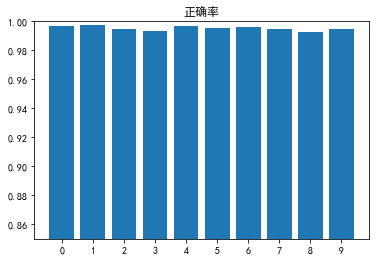

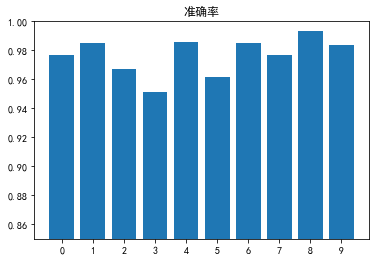

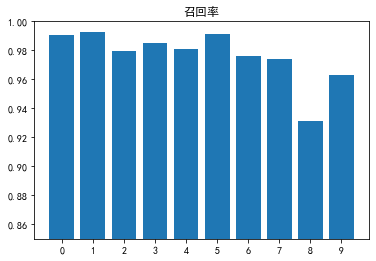

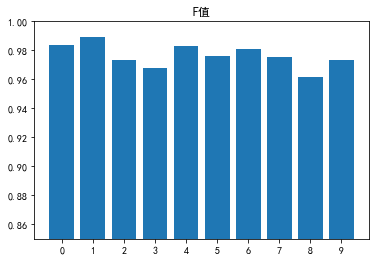

In [6]:
# 最后的评估标准是 总体的正确率、宏平均、微平均、小类评估
correct = 0
total = 0
result=Evaluator()
cnt=[[0]*3 for i in range(10)]

# 定义画柱形图的函数
def plotVisual2(y:list,title:str)->None:
    fig,ax=plt.subplots()
    ax.set_xticks(range(0,10))
    ax.set_title(title)
    ax.set_ylim(0.85,1.00)
    ax.bar([i for i in range(10)],y)
    return 

with torch.no_grad():# 进行评测的时候网络不更新梯度
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)# labels 的长度
        correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            # 第0列是正确分类为该数字的个数  cnt0
            # 1列是分类为改数字的总个数      cnt1
            # 2列是应该分类为改数字的个数    cnt2
            cnt[int(labels[i])][2]+=1
            cnt[int(predicted[i])][1]+=1
            if labels[i]==predicted[i]:
                cnt[int(labels[i])][0]+=1

print('总体的正确率是: {}\n'.format(round(correct/total,4)))
result.addTrainResult(cnt,total)

macro=result.MacroAvg[0]
micro=result.MicroAvg[0]
# 宏平均
print('宏平均:\n')
print('--------正确率:{}\n'.format(macro[0]))
print('--------准确率:{}\n'.format(macro[1]))
print('--------召回率:{}\n'.format(macro[2]))
print('-------- F值  :{}\n'.format(macro[3]))

# 微平均
print('微平均:\n')
print('--------正确率:{}\n'.format(micro[0]))
print('--------准确率:{}\n'.format(micro[1]))
print('--------召回率:{}\n'.format(micro[2]))
print('-------- F值  :{}\n'.format(micro[3]))

cols=[[result.ClassResult[i][0][0] for i in range(0,10)],
    [result.ClassResult[i][0][1] for i in range(0,10)],
    [result.ClassResult[i][0][2] for i in range(0,10)],
    [result.ClassResult[i][0][3] for i in range(0,10)]]
titles=['正确率','准确率','召回率','F值']
for y,title in zip(cols,titles):
    plotVisual2(y,title)

print('测试结束 . . . . . . . . .')